Image fat.jpg - Fat Area: 52.86%


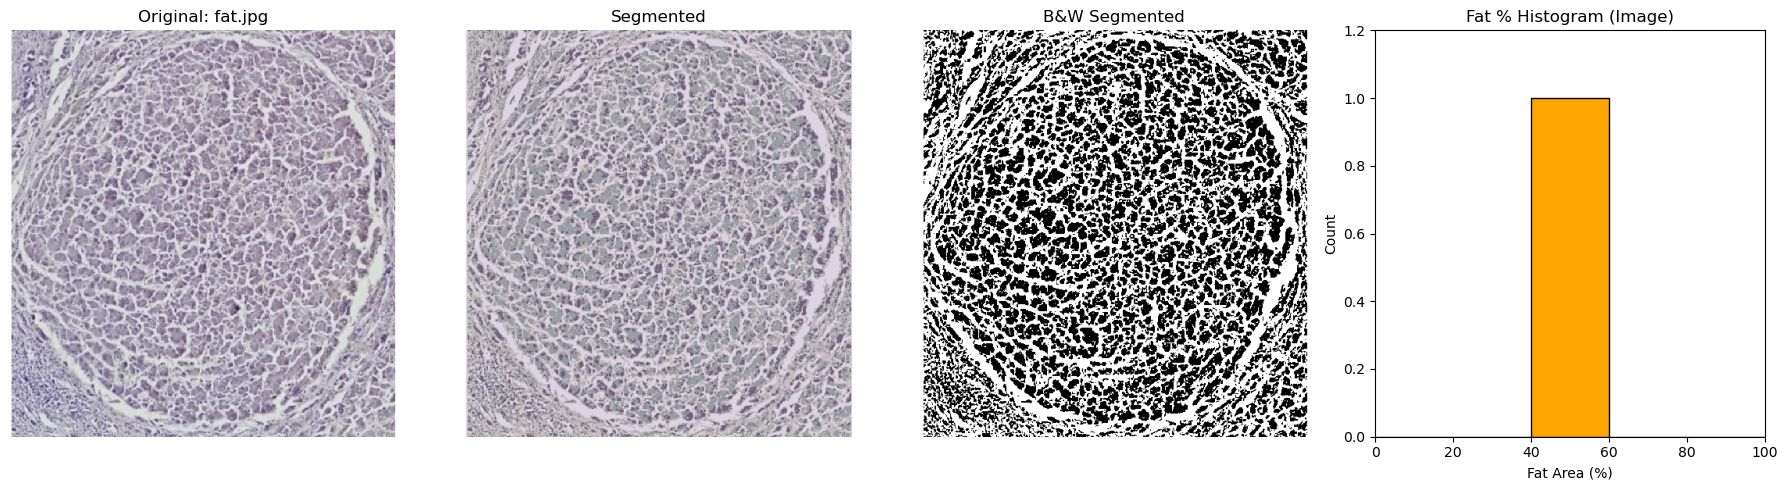

Image fat2.jpg - Fat Area: 37.89%


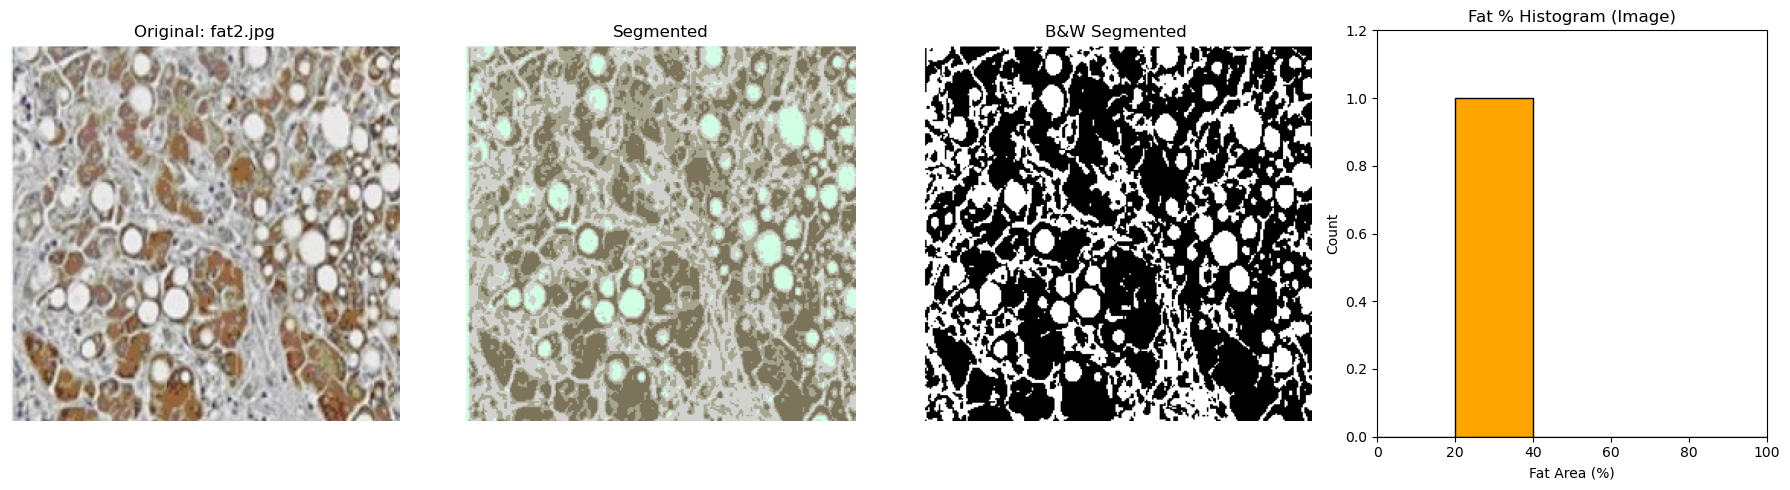

Image fat3.png - Fat Area: 30.45%


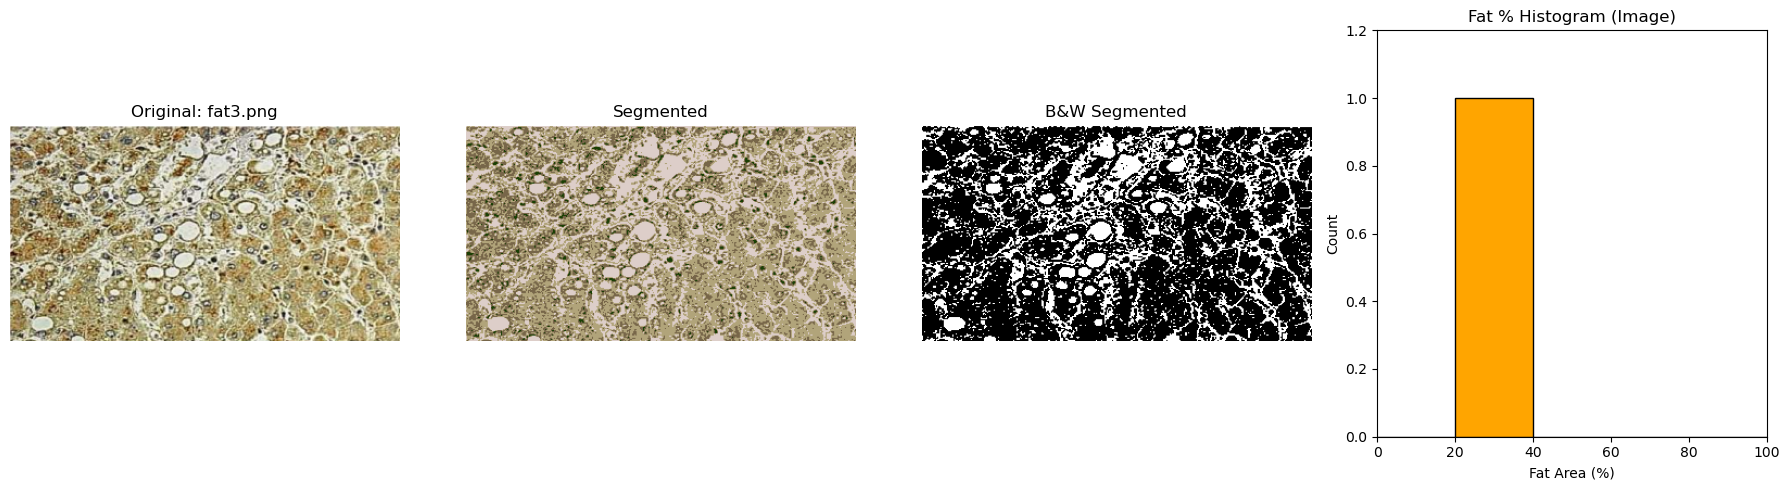

Image fat4.png - Fat Area: 47.64%


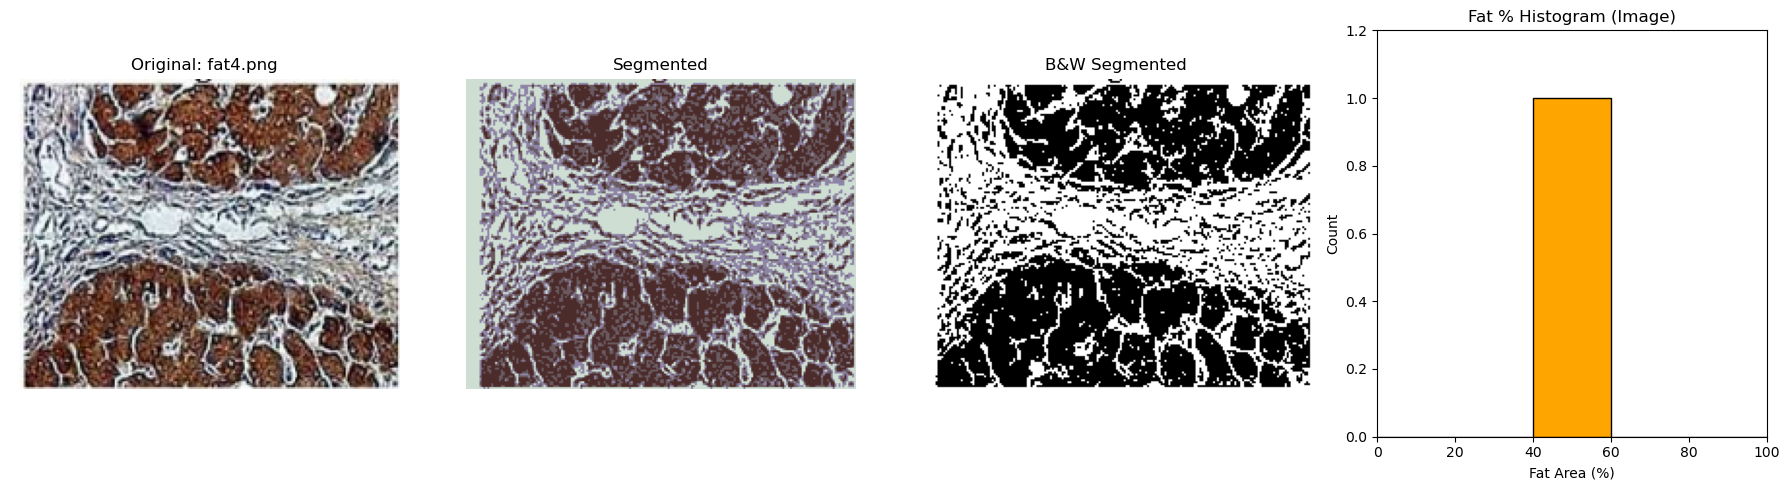

Image fat5.png - Fat Area: 38.20%


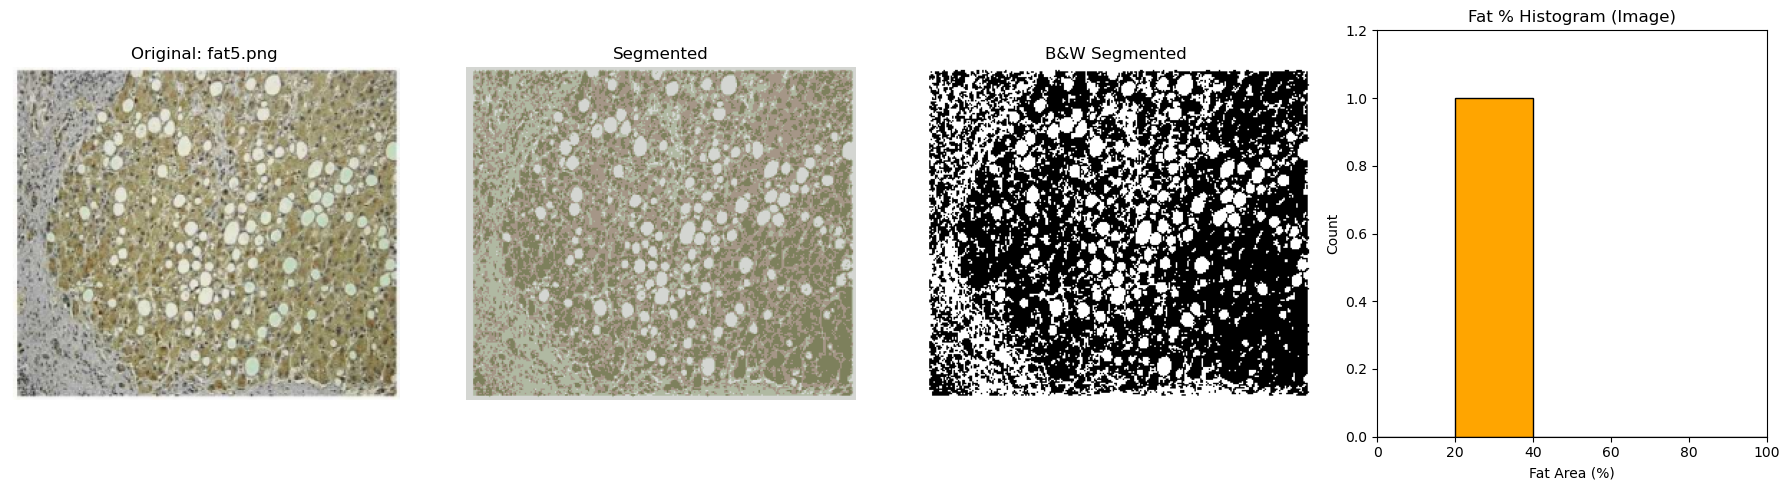

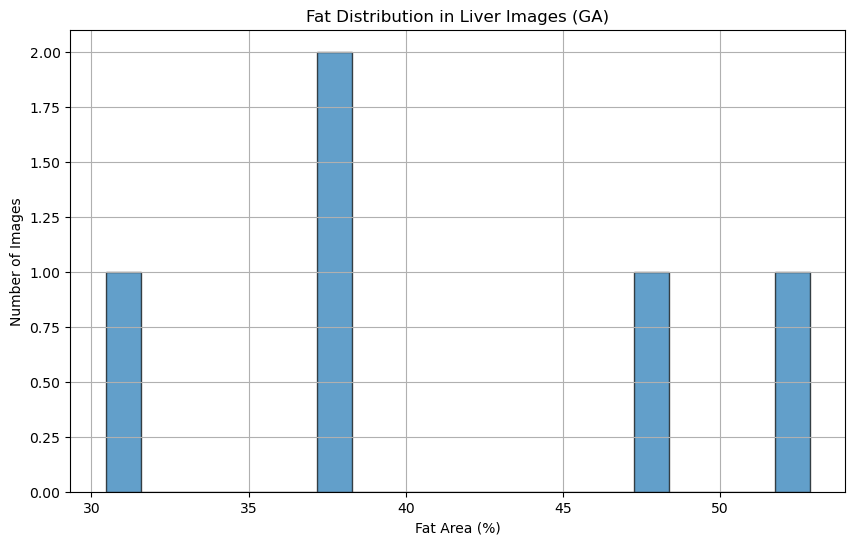


Fat Area Summary Table:
Filename  Fat Area (%)
 fat.jpg     52.863537
fat2.jpg     37.889044
fat3.png     30.448902
fat4.png     47.643035
fat5.png     38.197262


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd

# --- GA Segmentation Function ---
def ga_segment(image_array, n_segments, n_population=50, n_generations=100, mutation_rate=0.2):
    height, width, channels = image_array.shape
    flat_image = image_array.reshape((-1, channels))

    population = np.random.rand(n_population, n_segments, channels) * 255

    def fitness(individual):
        distances = np.linalg.norm(flat_image[:, None, :] - individual, axis=2)
        labels = np.argmin(distances, axis=1)
        sse = 0
        for i in range(n_segments):
            cluster_points = flat_image[labels == i]
            if len(cluster_points) > 0:
                sse += np.sum(np.linalg.norm(cluster_points - individual[i], axis=1) ** 2)
        return sse

    cost_values = []

    for gen in range(n_generations):
        fitness_vals = np.array([fitness(ind) for ind in population])
        best_idx = np.argmin(fitness_vals)
        best_fit = fitness_vals[best_idx]
        best_individual = population[best_idx]
        cost_values.append(best_fit)

        # Selection (Tournament)
        selected = []
        for _ in range(n_population):
            i, j = np.random.choice(n_population, 2, replace=False)
            selected.append(population[i] if fitness_vals[i] < fitness_vals[j] else population[j])
        selected = np.array(selected)

        # Crossover (Single Point)
        next_population = []
        for _ in range(n_population // 2):
            p1, p2 = selected[np.random.choice(n_population, 2, replace=False)]
            cp = np.random.randint(1, n_segments)
            child1 = np.vstack((p1[:cp], p2[cp:]))
            child2 = np.vstack((p2[:cp], p1[cp:]))
            next_population.extend([child1, child2])
        population = np.array(next_population)

        # Mutation
        for individual in population:
            if np.random.rand() < mutation_rate:
                idx = np.random.randint(n_segments)
                individual[idx] += np.random.normal(0, 10, channels)
                individual[idx] = np.clip(individual[idx], 0, 255)

    return best_individual, cost_values

# --- Helper Functions ---
def apply_segmentation(image_array, centroids):
    flat_image = image_array.reshape((-1, image_array.shape[2]))
    distances = np.linalg.norm(flat_image[:, None, :] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    segmented_image = centroids[labels].reshape(image_array.shape)
    return segmented_image.astype(np.uint8)

def to_black_and_white(image):
    gray = np.mean(image, axis=2)
    bw = (gray > gray.mean()).astype(np.uint8) * 255
    return bw

# --- Folder Processing with per-image visualization and summary table ---
def process_image_folder_ga(folder_path, n_segments=4, n_population=30, n_generations=50, mutation_rate=0.2):
    fat_areas = []
    filenames = []

    for filename in os.listdir(folder_path):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        try:
            path = os.path.join(folder_path, filename)
            image = np.array(Image.open(path).convert('RGB'))

            centroids, cost = ga_segment(image, n_segments, n_population, n_generations, mutation_rate)
            segmented = apply_segmentation(image, centroids)
            bw_segmented = to_black_and_white(segmented)

            fat_pixels = np.sum(bw_segmented == 255)
            total_pixels = bw_segmented.size
            fat_area_pct = (fat_pixels / total_pixels) * 100

            fat_areas.append(fat_area_pct)
            filenames.append(filename)

            print(f"Image {filename} - Fat Area: {fat_area_pct:.2f}%")

            # Plot Original, Segmented, B&W, and histogram for current image
            plt.figure(figsize=(18, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(image)
            plt.title(f'Original: {filename}')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(segmented)
            plt.title('Segmented')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(bw_segmented, cmap='gray')
            plt.title('B&W Segmented')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.hist([fat_area_pct], bins=5, range=(0, 100), color='orange', edgecolor='black')
            plt.title('Fat % Histogram (Image)')
            plt.xlabel('Fat Area (%)')
            plt.ylabel('Count')
            plt.xlim(0, 100)
            plt.ylim(0, 1.2)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Overall fat distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(fat_areas, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Fat Area (%)')
    plt.ylabel('Number of Images')
    plt.title('Fat Distribution in Liver Images (GA)')
    plt.grid(True)
    plt.show()

    # Summary table using pandas
    df = pd.DataFrame({'Filename': filenames, 'Fat Area (%)': fat_areas})
    print("\nFat Area Summary Table:")
    print(df.to_string(index=False))

    return fat_areas

# --- Run ---
folder_path = r'C:\Users\pc\Desktop\fatty lever data'
fat_areas_ga = process_image_folder_ga(folder_path)
